# Specify perturbation

In [3]:
import numpy as np

Ne = 10 # number of perturbation
amean = 20.0
bmean = 5.0
a_std = 2.0
b_std = 0.5
aw = np.random.normal(amean, a_std, Ne)  # perturbation in a
bw = np.random.normal(bmean, b_std, Ne)  # perturbation in b

aw, bw

(array([19.07507646, 22.72386187, 20.53657626, 19.98092782, 20.97883557,
        16.3174327 , 18.78459336, 19.79672986, 20.13959565, 18.78068726]),
 array([4.64541996, 5.69269463, 5.16111351, 5.24254823, 4.55721953,
        4.60332895, 5.60175059, 4.58154166, 5.5846927 , 5.41393161]))

# Stochastic OCP for initial state x0 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



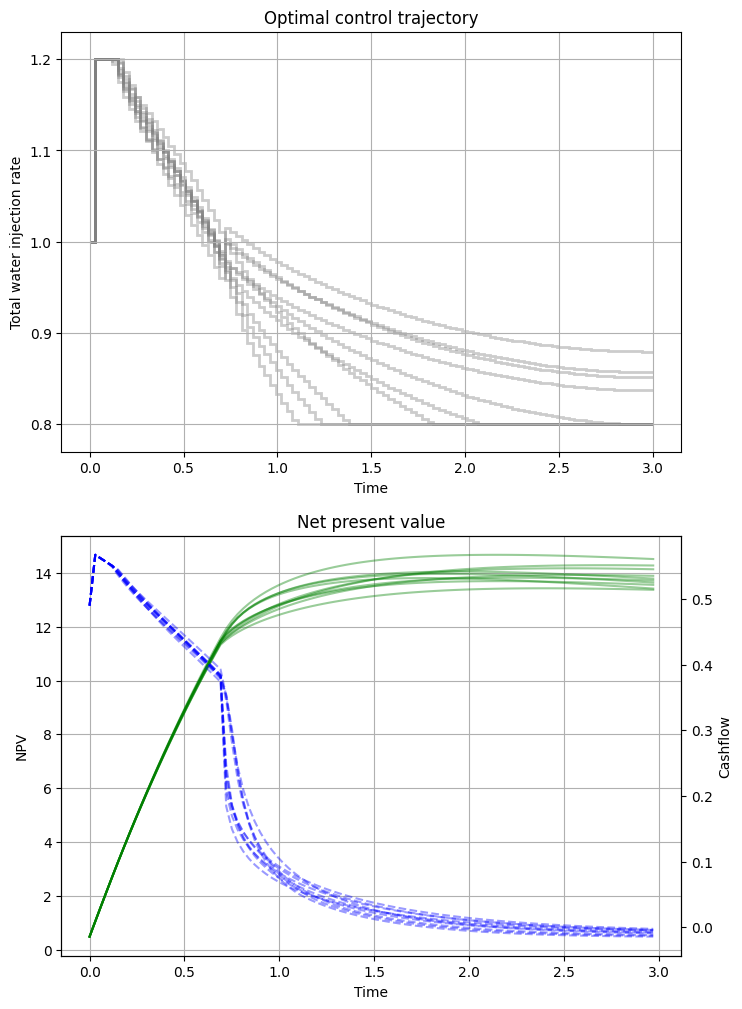

In [4]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from setup_bl import setup_bl_ocp, BLParamsMpc
from solver_ocp import SolverOcp

params_mpcs = [BLParamsMpc(a=a, b=b) for a,b in zip(aw, bw)]

fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].set_ylim(params_mpcs[0].umin-0.03, params_mpcs[0].umax+0.03)
axs[0].set_title('Optimal control trajectory')
axs[0].set_ylabel('Total water injection rate')
axs[0].set_xlabel('Time')
axs[0].grid(True)

axs[1].set_xlabel('Time')
axs[1].set_ylabel('NPV')
axs[1].set_title('Net present value')
axs[1].grid(True)
    
ocp_x_trajs = []
ocp_u_trajs = []
ocp_cashflows = []
for i in range(Ne):

    params_mpc = params_mpcs[i]
    ocp = setup_bl_ocp(params_mpc)
    solver = SolverOcp(ocp)


    Sw0 = np.array([1.0]+[0.2]*(params_mpc.nx-1))  # initial state
    qt = np.array([1.0]*params_mpc.N)  # initial guess for control

    solver.set_initial_guess(Sw0, qt)
    x_traj, u_traj = solver.solve(Sw0)

    T = np.array(range(params_mpc.N+1))*params_mpc.dt

    # plot control trajectory
    axs[0].stairs(u_traj[0,:], T, label='u', baseline=None, orientation='vertical', linewidth=2, color="grey", alpha=0.4, )


    # plot the cost
    cost_function = ca.Function('cost_function', [ocp.u, ocp.x], [ocp.stage_cost_expr])
    ocp_cashflow = np.zeros(params_mpc.N)
    npv = []
    for k in range(params_mpc.N):
        ocp_cashflow[k] = -cost_function(u_traj[0,k], x_traj[:,k])*0.99**(k)
        npv.append(ocp_cashflow[k] if k==0 else npv[-1] + ocp_cashflow[k])
            
    axs[1].plot(T[:-1], npv, color="green", alpha=0.4, label='NPV')
    

    # plot twin axis for cashflow
    # ax1 = axs[1].gca()
    if i == 0:
        ax = axs[1].twinx()
        ax.set_ylabel("Cashflow")
    
    ax.plot(T[:-1], ocp_cashflow, '--', label='Cashflow', color="blue", alpha=0.4)
    
    # plt.show()

    ocp_x_traj = x_traj*1
    ocp_u_traj = u_traj*1

    ocp_npv = npv*1
    
    ocp_x_trajs.append(ocp_x_traj)
    ocp_u_trajs.append(ocp_u_traj)
    ocp_cashflows.append(ocp_cashflow)

np.save("./data/stochastic_ocp_cashflows.npy", ocp_cashflows)
np.save("./data/stochastic_ocp_sw_trajs.npy", ocp_x_trajs)
np.save("./data/stochastic_ocp_qts.npy", ocp_u_trajs)

In [5]:
n_mpc_steps = 100

# Stochastic Model Predictive Control with Moving Horizon 
(time window = 3 sec (N = 100, dt = 0.03))

In [6]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_sbl import setup_sbl_ocp, BLParamsSmpc
from solver_socp import SolverOcp

n_mpc_steps = 100
if False: # long running simulation
    params_mpc = BLParamsSmpc()

    nx = params_mpc.nx
    _Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
    Sw0 = np.array(_Sw0*params_mpc.Ne)  # initial state
    qt = np.array([1.0]*params_mpc.N)  # initial guess for control

    qt_sol = []
    Sw_mpc = Sw0.copy()
    qt_mpc = []
    Sw_traj = [Sw_mpc.copy()]
    cashflows = []
    npvs_mpc = [[0.0]*params_mpc.Ne]

    for mpc_step in tqdm(range(n_mpc_steps)):

        # update stage constraint
        params_mpc.uinit = qt[0]

        # solve OCP
        ocp = setup_sbl_ocp(params_mpc)
        cost_function = [ca.Function(f'cost_function_{i}', [ocp.u, ocp.x], [stage_cost_expr]) for i, stage_cost_expr in enumerate(ocp.stage_cost_expr)]
        f_discrete = [ca.Function(f"f_discrete_{i}", [ocp.u, ocp.x], [dyn_expr]) for i, dyn_expr in enumerate(ocp.dyn_expr)]

        solver = SolverOcp(ocp, itk=mpc_step)
        
        solver.set_initial_guess(Sw_mpc, qt)
        x_traj, u_traj = solver.solve(Sw_mpc)
        qt_sol.append(u_traj[0,0]*1)
        
        # apply the first control move
        qt_mpc.append(u_traj[0,:])
        
       
        _Sw_mpc = []
        for i in range(params_mpc.Ne):
            adf = f_discrete[i](u_traj[0,0], Sw_mpc).full()[:,0]
            _Sw_mpc.append(adf)
            
    
        cashflow = []
        npv_mpc = []
        for i in range(params_mpc.Ne):
            # cashflow.append(-(cost_function(u_traj[0,0], Sw_mpc[:,:,i])*0.99**(mpc_step)).full()[0,0])
            cashflow.append(-(cost_function[i](u_traj[0,0], Sw_mpc)*0.99**(mpc_step)).full()[0,0])
            npv_mpc.append((npvs_mpc[-1][i] + cashflow[i]))
        
        
        Sw_mpc = ca.vertcat(*_Sw_mpc).full()[:,0]
        
        Sw_traj.append(Sw_mpc)
        
        cashflows.append(cashflow)
        npvs_mpc.append(npv_mpc)
        
        # shift the control trajectory
        qt = np.hstack((u_traj[0,1:], u_traj[0,-1]))
        
    cashflow_full = np.array(cashflows)
    Sw_traj_full = np.array(Sw_traj)
    qt_mpc_full = np.array(qt_mpc)

    np.save("./data/stochastic_cashflow_full.npy", cashflow_full)
    np.save("./data/stochastic_sw_traj_full.npy", Sw_traj_full)
    np.save("./data/stochastic_qt_mpc_full.npy", qt_mpc_full)

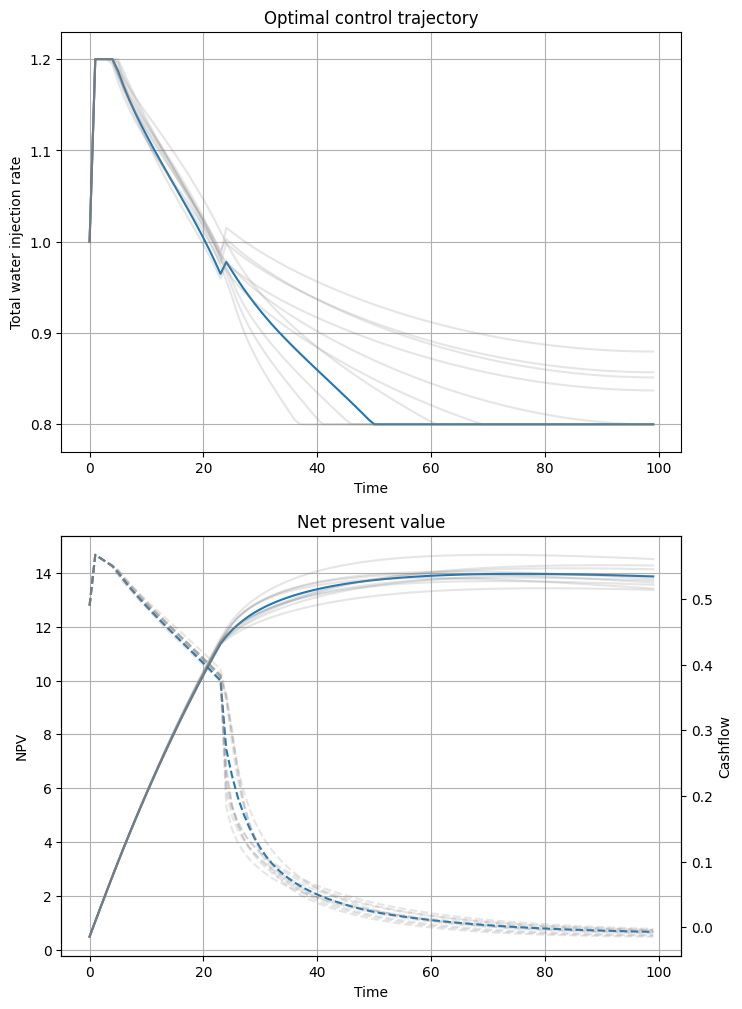

In [7]:
cashflow_full = np.load("./data/stochastic_cashflow_full.npy")
Sw_traj_full = np.load("./data/stochastic_sw_traj_full.npy")
qt_mpc_full = np.load("./data/stochastic_qt_mpc_full.npy")

ocp_cashflows = np.load("./data/stochastic_ocp_cashflows.npy")
ocp_x_trajs = np.load("./data/stochastic_ocp_sw_trajs.npy")
ocp_u_trajs = np.load("./data/stochastic_ocp_qts.npy")

fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].set_ylim(params_mpc.umin-0.03, params_mpc.umax+0.03)
axs[0].set_title('Optimal control trajectory')
axs[0].set_ylabel('Total water injection rate')
axs[0].set_xlabel('Time')
axs[0].grid(True)

axs[1].set_xlabel('Time')
axs[1].set_ylabel('NPV')
axs[1].set_title('Net present value')
axs[1].grid(True)

axs[0].plot(qt_mpc_full[:,0])
axs[0].plot(ocp_u_trajs[:,0,:].T, color="grey", alpha=0.2)


smpc_cashflow = np.mean(cashflow_full, axis=1)
smpc_npv = np.cumsum(smpc_cashflow)
axs[1].plot(np.cumsum(smpc_cashflow))
axs[1].plot(np.cumsum(ocp_cashflows.T, axis=0), color="grey", alpha=0.2)

ax = axs[1].twinx()
ax.set_ylabel("Cashflow")

ax.plot(smpc_cashflow, '--', label='Cashflow')
ax.plot(ocp_cashflows.T, '--', label='Cashflow', color="grey", alpha=0.2)


# Model Predictive Control with Moving Horizon 
(time window = 1.5 sec (N = 100, dt = 0.03))

In [8]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_sbl import setup_sbl_ocp, BLParamsSmpcShort
from solver_socp import SolverOcp

n_mpc_steps = 100
if True: # long running simulation
    params_mpc = BLParamsSmpcShort()

    nx = params_mpc.nx
    _Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
    Sw0 = np.array(_Sw0*params_mpc.Ne)  # initial state
    qt = np.array([1.0]*params_mpc.N)  # initial guess for control

    qt_sol = []
    Sw_mpc = Sw0.copy()
    qt_mpc = []
    Sw_traj = [Sw_mpc.copy()]
    cashflows = []
    npvs_mpc = [[0.0]*params_mpc.Ne]

    for mpc_step in tqdm(range(n_mpc_steps)):

        # update stage constraint
        params_mpc.uinit = qt[0]

        # solve OCP
        ocp = setup_sbl_ocp(params_mpc)
        cost_function = [ca.Function(f'cost_function_{i}', [ocp.u, ocp.x], [stage_cost_expr]) for i, stage_cost_expr in enumerate(ocp.stage_cost_expr)]
        f_discrete = [ca.Function(f"f_discrete_{i}", [ocp.u, ocp.x], [dyn_expr]) for i, dyn_expr in enumerate(ocp.dyn_expr)]

        solver = SolverOcp(ocp, itk=mpc_step)
        
        solver.set_initial_guess(Sw_mpc, qt)
        x_traj, u_traj = solver.solve(Sw_mpc)
        qt_sol.append(u_traj[0,0]*1)
        
        # apply the first control move
        qt_mpc.append(u_traj[0,:])
        
       
        _Sw_mpc = []
        for i in range(params_mpc.Ne):
            adf = f_discrete[i](u_traj[0,0], Sw_mpc).full()[:,0]
            _Sw_mpc.append(adf)
            
    
        cashflow = []
        npv_mpc = []
        for i in range(params_mpc.Ne):
            # cashflow.append(-(cost_function(u_traj[0,0], Sw_mpc[:,:,i])*0.99**(mpc_step)).full()[0,0])
            cashflow.append(-(cost_function[i](u_traj[0,0], Sw_mpc)*0.99**(mpc_step)).full()[0,0])
            npv_mpc.append((npvs_mpc[-1][i] + cashflow[i]))
        
        
        Sw_mpc = ca.vertcat(*_Sw_mpc).full()[:,0]
        
        Sw_traj.append(Sw_mpc)
        
        cashflows.append(cashflow)
        npvs_mpc.append(npv_mpc)
        
        # shift the control trajectory
        qt = np.hstack((u_traj[0,1:], u_traj[0,-1]))
        
    cashflow_half = np.array(cashflows)
    Sw_traj_half = np.array(Sw_traj)
    qt_mpc_half = np.array(qt_mpc)

    np.save("./data/stochastic_cashflow_half.npy", cashflow_half)
    np.save("./data/stochastic_sw_traj_half.npy", Sw_traj_half)
    np.save("./data/stochastic_qt_mpc_half.npy", qt_mpc_half)

  0%|          | 0/100 [00:00<?, ?it/s]

# State and control trajectories at each time steps

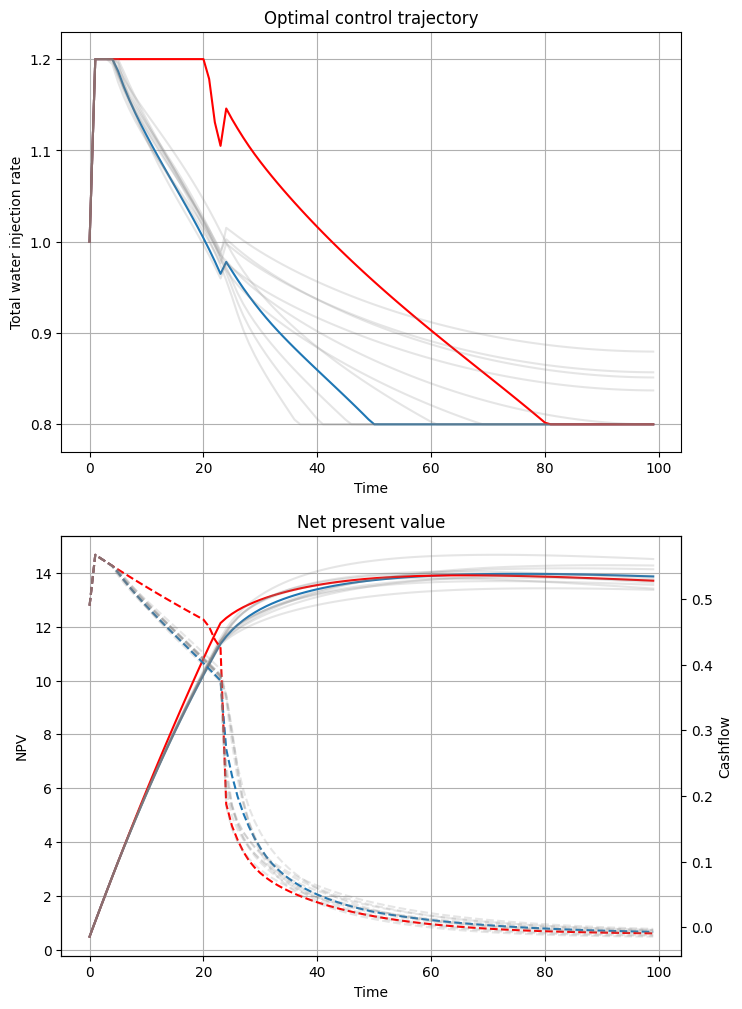

In [10]:
cashflow_full = np.load("./data/stochastic_cashflow_full.npy")
Sw_traj_full = np.load("./data/stochastic_sw_traj_full.npy")
qt_mpc_full = np.load("./data/stochastic_qt_mpc_full.npy")

cashflow_half = np.load("./data/stochastic_cashflow_half.npy")
Sw_traj_half = np.load("./data/stochastic_sw_traj_half.npy")
qt_mpc_half = np.load("./data/stochastic_qt_mpc_half.npy")

ocp_cashflows = np.load("./data/stochastic_ocp_cashflows.npy")
ocp_x_trajs = np.load("./data/stochastic_ocp_sw_trajs.npy")
ocp_u_trajs = np.load("./data/stochastic_ocp_qts.npy")

fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].set_ylim(params_mpc.umin-0.03, params_mpc.umax+0.03)
axs[0].set_title('Optimal control trajectory')
axs[0].set_ylabel('Total water injection rate')
axs[0].set_xlabel('Time')
axs[0].grid(True)

axs[1].set_xlabel('Time')
axs[1].set_ylabel('NPV')
axs[1].set_title('Net present value')
axs[1].grid(True)

axs[0].plot(qt_mpc_full[:,0])
axs[0].plot(qt_mpc_half[:,0], color="red")
axs[0].plot(ocp_u_trajs[:,0,:].T, color="grey", alpha=0.2)


smpc_cashflow_full = np.mean(cashflow_full, axis=1)
smpc_cashflow_half = np.mean(cashflow_half, axis=1)
smpc_npv_full = np.cumsum(smpc_cashflow_full)
smpc_npv_half = np.cumsum(smpc_cashflow_half)
axs[1].plot(np.cumsum(smpc_cashflow_full))
axs[1].plot(np.cumsum(smpc_cashflow_half), color="red")
axs[1].plot(np.cumsum(ocp_cashflows.T, axis=0), color="grey", alpha=0.2)

ax = axs[1].twinx()
ax.set_ylabel("Cashflow")

ax.plot(smpc_cashflow_full, '--', label='Cashflow')
ax.plot(smpc_cashflow_half, '--', label='Cashflow', color="red")
ax.plot(ocp_cashflows.T, '--', label='Cashflow', color="grey", alpha=0.2)